In [72]:
import pathlib
import os
import time
import base64
from ctypes import byref, cast, POINTER, c_int, c_uint, c_float
import seaborn as sns
import libximc as ximc
import pandas as pd
import numpy as np
import serial
from IPython import display
import openpyxl

In [2]:
probe_flags = ximc.EnumerateFlags.ENUMERATE_PROBE + ximc.EnumerateFlags.ENUMERATE_NETWORK
enum_hint=b"addr="
devices_info = ximc.lib.enumerate_devices(probe_flags, enum_hint)
n_devices = ximc.lib.get_device_count(devices_info)

# Print real devices list
if n_devices > 0:
    print("Found {} real device(s):".format(n_devices))
    for i in range(n_devices):
        enum_name = ximc.lib.get_device_name(devices_info, i)
        print("  {}".format(enum_name.decode()))
else:
    print("The real devices were not found. A virtual device will be used.")

Found 2 real device(s):
  xi-com:\\.\COM10
  xi-com:\\.\COM9


In [3]:
device_uri_axis1 = "xi-com:\\\\.\\COM10" # horizontal
device_uri_axis2 = "xi-com:\\\\.\\COM9" # vertical
 
device_id1 = ximc.lib.open_device(device_uri_axis1.encode()) # horizontal
device_id2 = ximc.lib.open_device(device_uri_axis2.encode()) # vertical

if device_id1 > 0:
    print("Device with URI {} successfully opened".format(device_uri_axis1))
else:
    raise RuntimeError("Failed to open device with URI", device_uri_axis2)

if device_id2 > 0:
    print("Device with URI {} successfully opened".format(device_uri_axis2))
else:
    raise RuntimeError("Failed to open device with URI", device_uri_axis2)


Device with URI xi-com:\\.\COM10 successfully opened
Device with URI xi-com:\\.\COM9 successfully opened


In [32]:
position1 = ximc.get_position_t()

ximc.lib.get_position(device_id1, byref(position1))
print("Initial position, horizontal:", position1.Position)

position2 = ximc.get_position_t()

ximc.lib.get_position(device_id2, byref(position2))
print("Initial position, vertical:", position2.Position)

pos1, pos2 = position1.Position, position2.Position

Initial position, horizontal: -5208
Initial position, vertical: 1620


In [5]:
print("РЕЗУЛЬТАТ ЮСТИРОВКИ ВДВОЕМ: horizontal {}, vertical {}".format(pos1, pos2))

РЕЗУЛЬТАТ ЮСТИРОВКИ ВДВОЕМ: horizontal -5208, vertical 1620


In [50]:
try:
    s = serial.Serial('COM8',115200)
except IOError: 
    print('no counter')

In [60]:
s.reset_input_buffer()
raw = s.readline().decode(errors = 'ignore')
try:
    reading = [int(float(part.strip())) for part in raw.split('\t')]
    print(reading)
except:
    print('хуян.doc')

[2694, 3300, 122]


In [22]:
s.close()

In [53]:
ximc.lib.command_move(device_id1, pos1, 0)
ximc.lib.command_move(device_id2, pos2, 0)

0

COMPLETE 100.0%


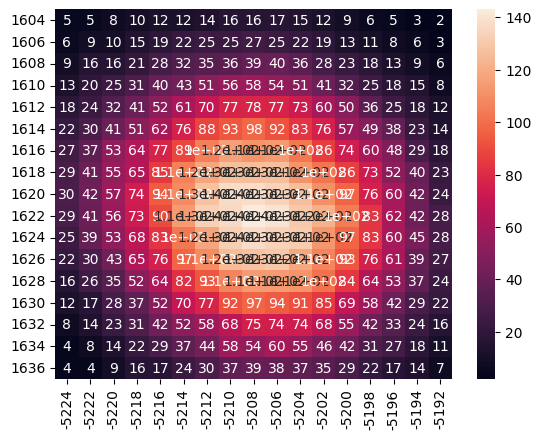

In [61]:
N = 8
length = 15
step = 2

columns = np.arange(-N * step + int(pos1), int(pos1) + N * step + step, step)
rows = np.arange(-N * step + int(pos2), int(pos2) + N * step + step, step)

data = pd.DataFrame(index=rows, columns=columns)
data = data.fillna(0)

count = 0

for x in columns:

    for y in rows:

        display.clear_output(wait=True)

        time.sleep(1)

        ximc.lib.command_move(device_id2, int(y), 0)
        ximc.lib.command_move(device_id1, int(x), 0)

        time.sleep(1)

        coin = []
        temp = 0
        for _ in range(length):
            s.reset_input_buffer()
            raw = s.readline().decode(errors = 'ignore')
            try:
                reading = [int(float(part.strip())) for part in raw.split('\t')]
                coin.append(reading[-1])
            except:
                print('хуян.doc')
            
        try:
            temp =  int(np.mean(coin))
        except:
            temp = 0

        data[x][y] = temp

        count += 1
        print("COMPLETE {}%".format(100 * count / ((2*N+1)*(2*N+1))))

    time.sleep(2)

data = data.astype(int)
sns.heatmap(data, annot=True)

ximc.lib.command_move(device_id1, pos1, 0)
ximc.lib.command_move(device_id2, pos2, 0)

s.close()

<Axes: >

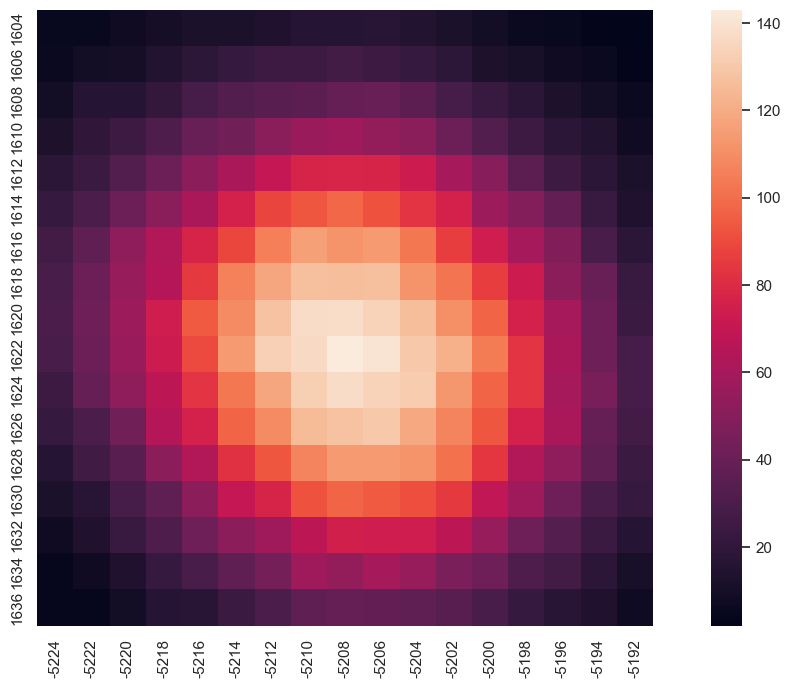

In [68]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.heatmap(data, square=True)

In [73]:
data.to_excel('моторизованное зеркало 20 07 2023.xlsx')